# **Latin Authorship Attribution**
<hr>
This is the notebook for Rufus Behr's CS4040 Mini-Project


### Module Imports

First, let us run fetch.py to create the necessary CLTK paths

In [2]:
from Data import fetch
fetch.text_retrieval()

Retrieving Perseus Texts
Retrieving Latin Library Texts.10 MiB/s 
Retrieving "Italian Poets in Latin" Texts
Retrieving CLTK Tesserae Latin Corpus/s 
Retrieving the Grammaticorum Latinorum Texts
Installing Language Models 2.61 MiB/s 
CLTK message: This part of the CLTK depends upon word embedding models from the NLPL project.
Do you want to download file 'http://vectors.nlpl.eu/repository/20/56.zip' to '/home/rufus/Desktop/LatinAuthorshipAttribution/Data/texts/lat/embeddings/nlpl/56.zip'? [Y/n] 
y


100%|███████████████████████████████████████| 419M/419M [02:36<00:00, 2.68MiB/s]


In [15]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/rufus/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [1]:
import numpy as np
import plot
import os, re
from Data import dataExp
%matplotlib inline
from matplotlib import pyplot as plt
import LatinBERT
from LatinBERT.gen_berts import LatinBERT
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=UserWarning)
    from cltk.tokenizers.lat.lat import LatinWordTokenizer as WordTokenizer
    from cltk.tokenizers.lat.lat import LatinPunktSentenceTokenizer as SentenceTokenizer
from cltk.embeddings.embeddings import Word2VecEmbeddings as W2VE
from sklearn import metrics
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import umap.umap_ as umap
import umap.plot

/home/rufus/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-12-04 22:37:17.769092: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-04 22:37:17.906009: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-04 22:37:17.906022: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your 

In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import rand_score
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score

In [3]:
from cltk.prosody.lat.macronizer import Macronizer
from cltk.prosody.lat.scanner import Scansion
from tqdm import tqdm

## Data Preprocessing:
The data has already been preprocessed and stored in the corpus.pickle file.
text_corpus.pickle contains a plaintext version of the corpus, as for the semantic embeddings further tokenization will either not take place (as is the case for Word2Vec) or happens within the model (as is the case for LatinBERT)

In [4]:
CI = dataExp.CorpusInterface(corpus_name="text_corpus.pickle", shouldTokenize = False)
preprocessed_CI = dataExp.CorpusInterface(corpus_name="corpus.pickle", shouldTokenize = True)

Found the existing corpus
abbofloracensis had 1 pieces of work with a total of 34398 characters of text
abelard had 1 pieces of work with a total of 15483 characters of text
acticussincerius had 1 pieces of work with a total of 15967 characters of text
addison had 1 pieces of work with a total of 7390 characters of text
adso had 1 pieces of work with a total of 13551 characters of text
aelredus had 1 pieces of work with a total of 118173 characters of text
agnes had 1 pieces of work with a total of 74784 characters of text
alanus had 1 pieces of work with a total of 195061 characters of text
albericodamarcellise had 1 pieces of work with a total of 172 characters of text
albertanus had 1 pieces of work with a total of 40604 characters of text
albertofaix had 1 pieces of work with a total of 118729 characters of text
alcuin had 1 pieces of work with a total of 70404 characters of text
aleandrogerolamo had 1 pieces of work with a total of 10197 characters of text
alfonsi had 1 pieces of 

Found the existing corpus
abbofloracensis had 1 pieces of work with a total of 4630 characters of text
abelard had 1 pieces of work with a total of 2258 characters of text
acticussincerius had 1 pieces of work with a total of 894 characters of text
addison had 1 pieces of work with a total of 430 characters of text
adso had 1 pieces of work with a total of 1961 characters of text
aelredus had 1 pieces of work with a total of 16943 characters of text
agnes had 1 pieces of work with a total of 10165 characters of text
alanus had 1 pieces of work with a total of 27945 characters of text
albericodamarcellise had 1 pieces of work with a total of 26 characters of text
albertanus had 1 pieces of work with a total of 19166 characters of text
albertofaix had 1 pieces of work with a total of 11592 characters of text
alcuin had 1 pieces of work with a total of 153 characters of text
aleandrogerolamo had 1 pieces of work with a total of 1555 characters of text
alfonsi had 1 pieces of work with a t

### Initial Data Exploratory Analysis

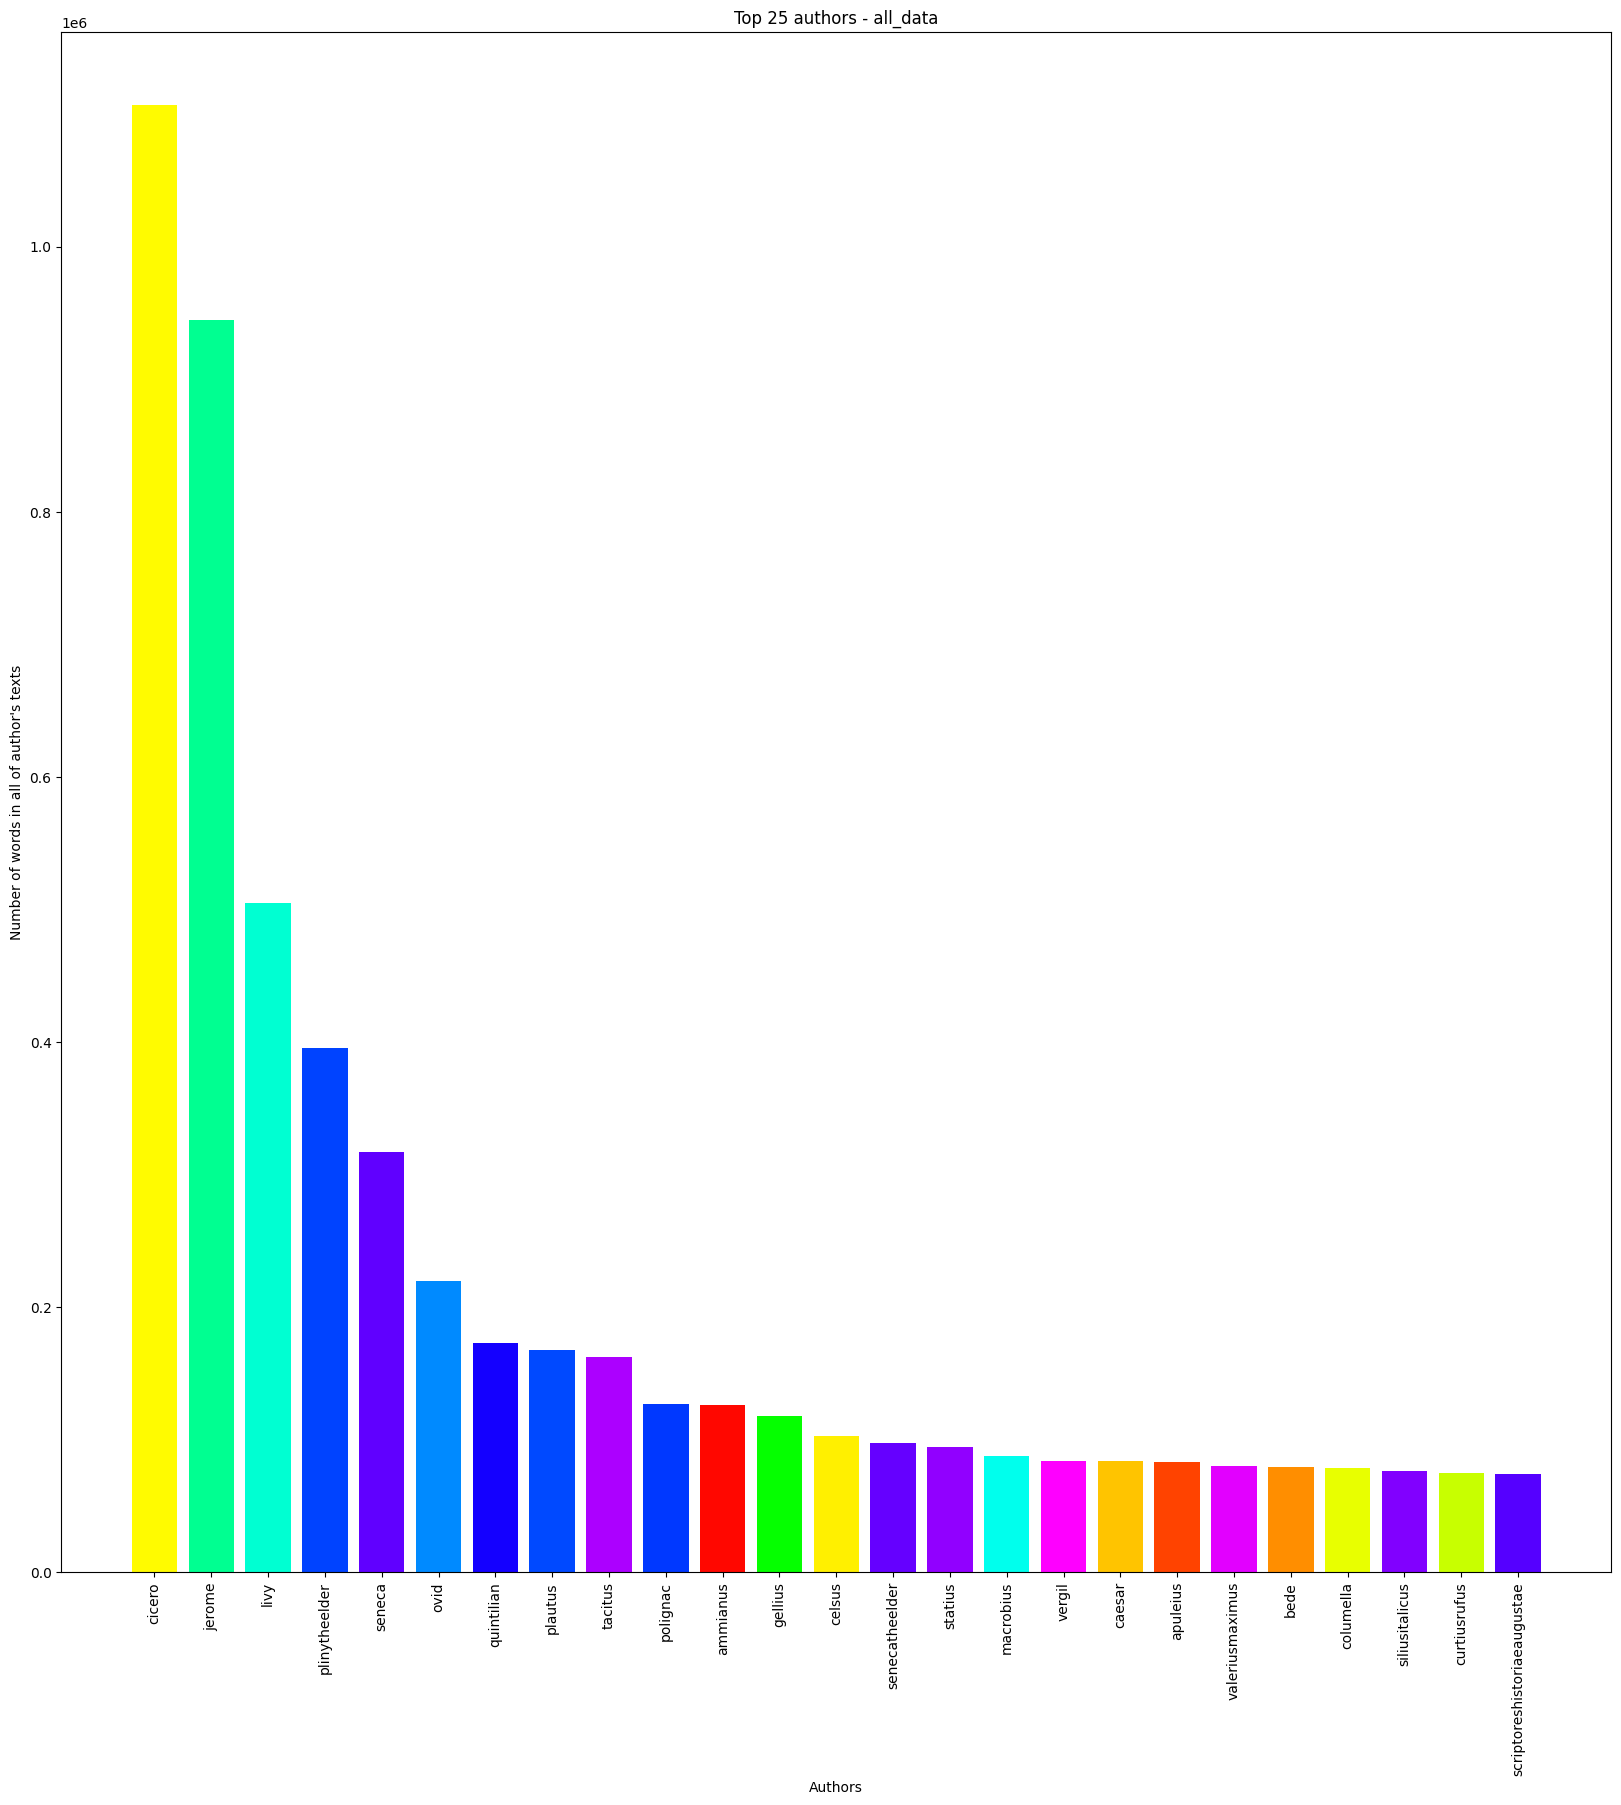

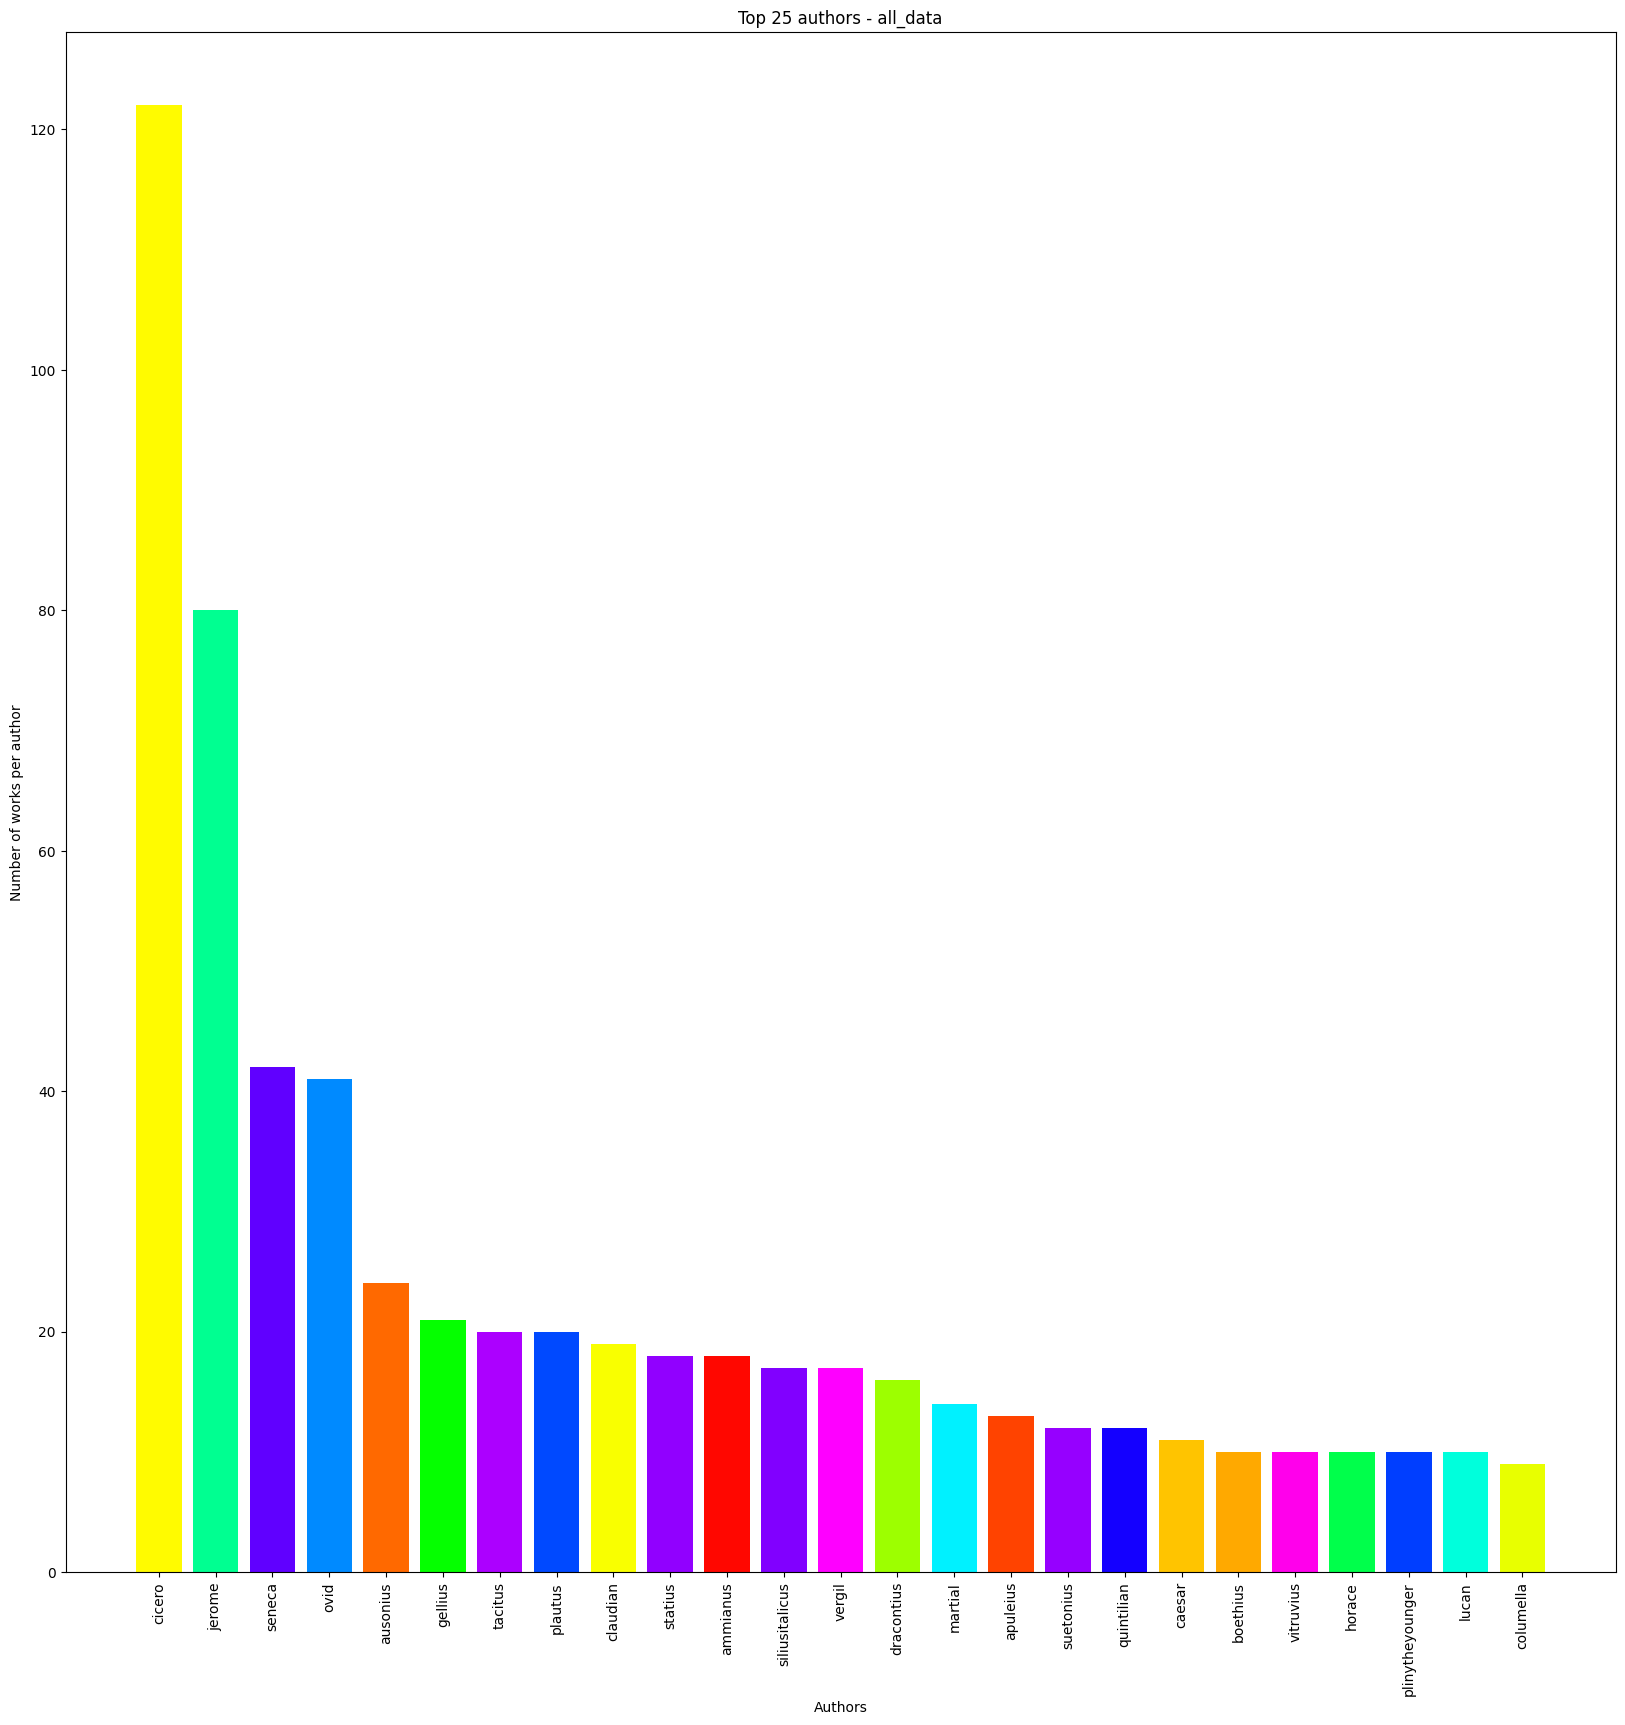

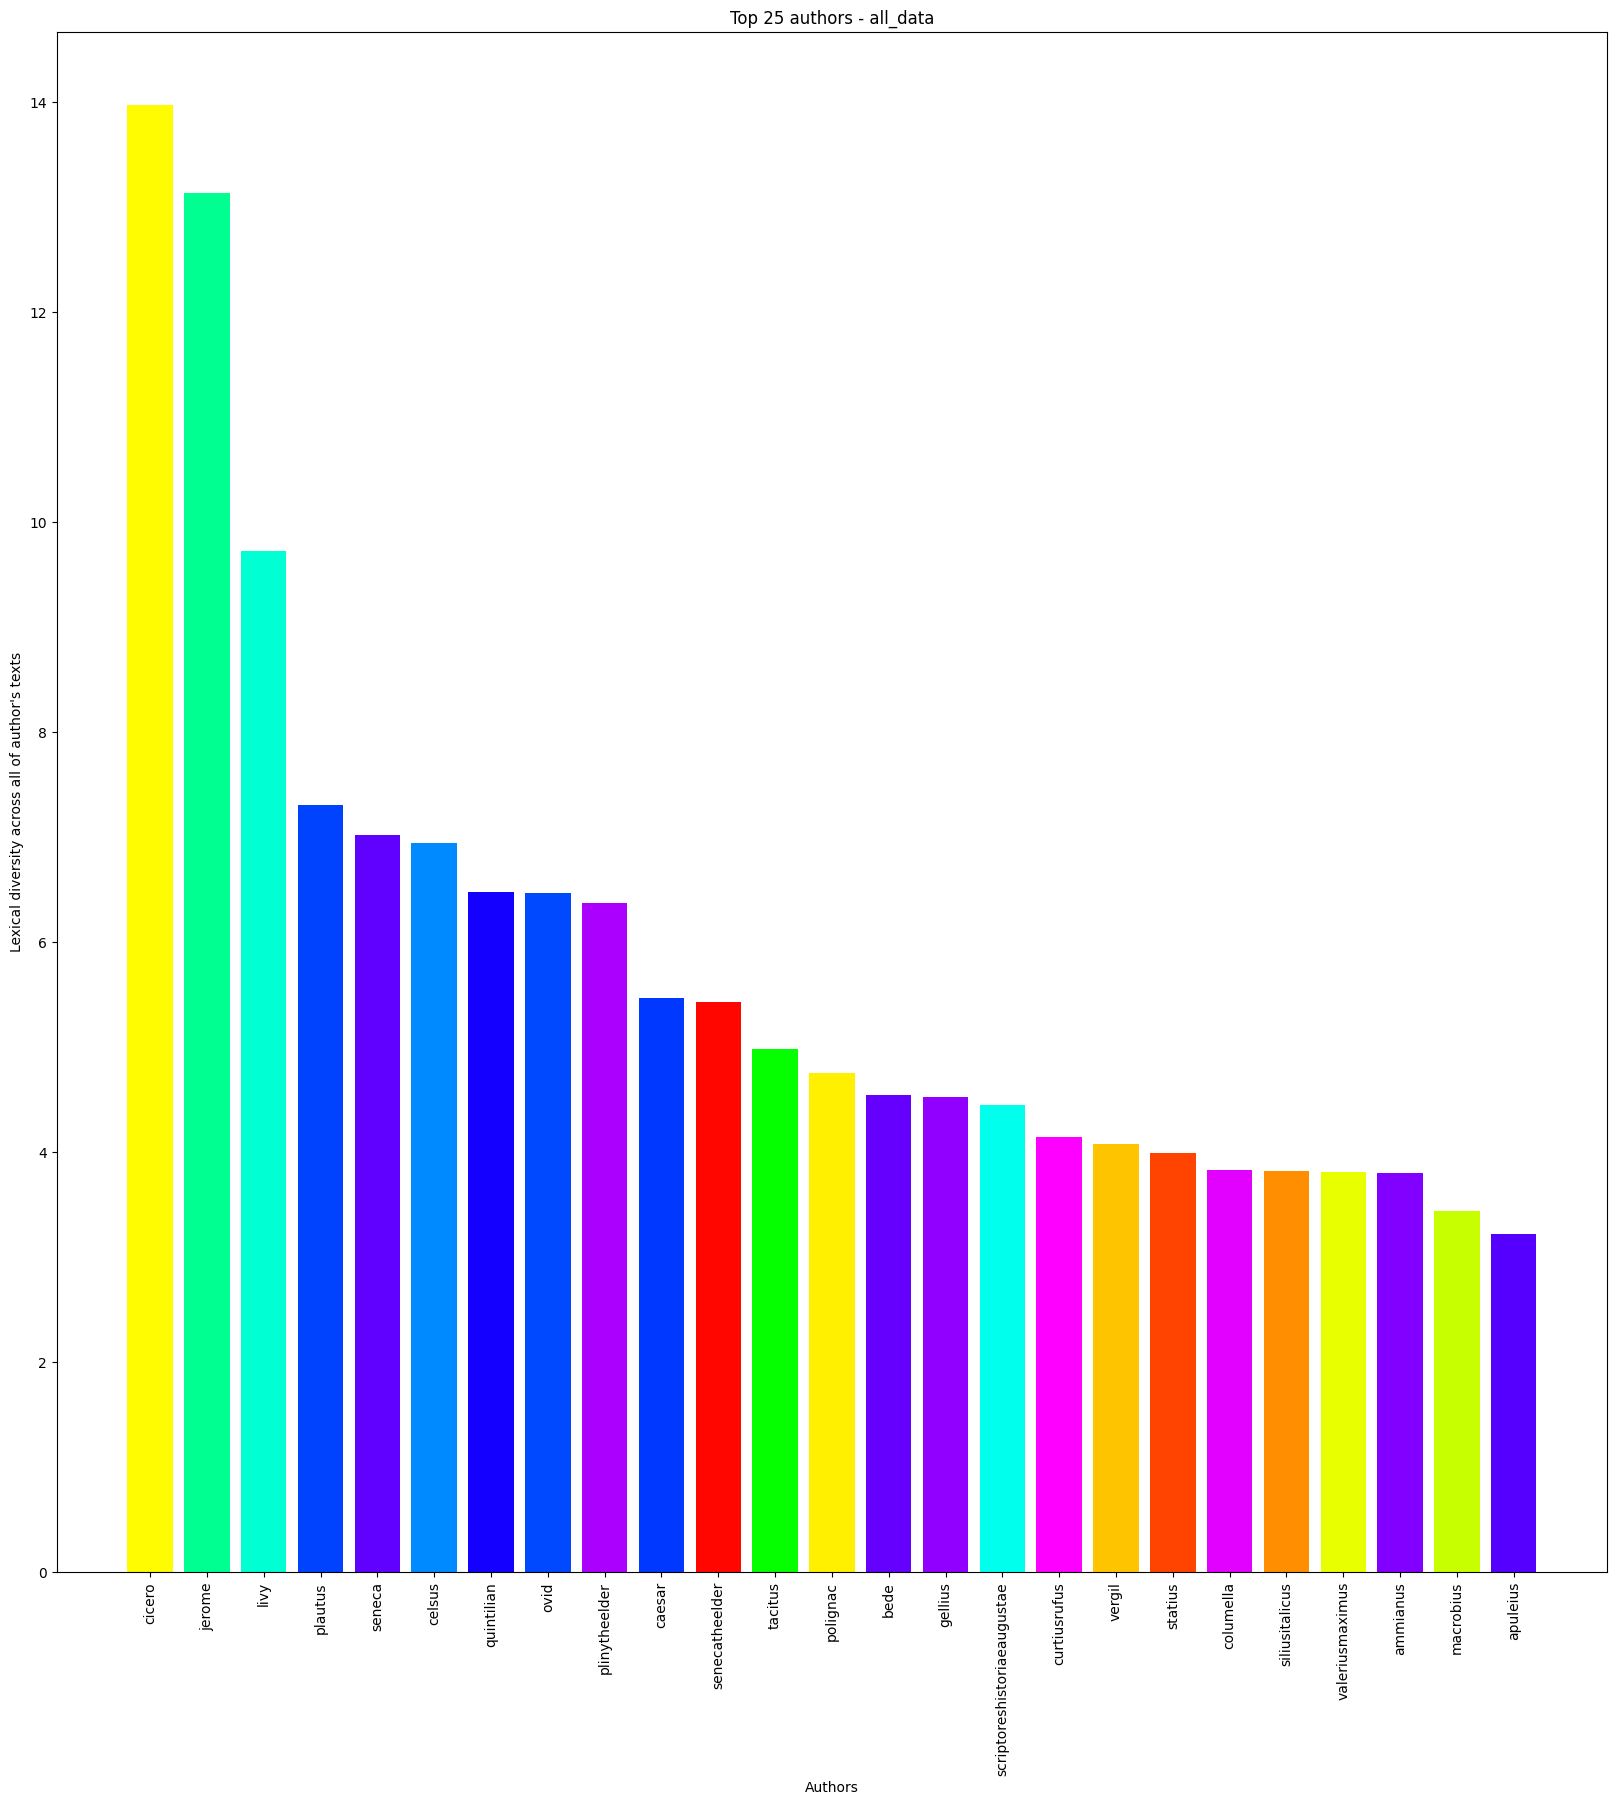

In [6]:
topAuthorsByTextLength, authors = plot.author_text_length_plot(preprocessed_CI, n_authors=25)
topAuthorsByWorkCount = plot.author_work_count_plot(preprocessed_CI, n_authors=25)
plot.author_lexical_diversity_plot(preprocessed_CI, authors)

# Experiments
Research Questions
1. Are the styles of the Latin texts distinct enough to accurately classify by author? Additionally, how do the varying embeddings, both word and lemma, compare in encoding the semantic relation between documents to perform this task?
2. Is it possible to identify the most important stylometric features for authorship attribution? If so, what are they?

<hr> 

## Semantic Analysis

To address the first research question ....

Let's load in our 2 models


In [ ]:
"""tokenizerPath = 'LatinBERT/latin.subword.encoder'
bertPath = 'LatinBERT/latin_bert/'
lat_bert = LatinBERT(tokenizerPath=tokenizerPath, bertPath=bertPath)"""

In [8]:
w2v = W2VE("lat")
# will be necessary for the word2vec tokenizer
st = SentenceTokenizer()
wt = WordTokenizer()

Before using word2vec's model, let's write a function that performs the equivalent of get_berts in gen_berts for CLTK's word2vec model.
The main difference is that in our retrieval of embeddings and authors instead of returning a list of of size 2 of respective embeddings and authors it returns a list the size of the sentences where each i details the sentence and the author as a list pair.

In [9]:
def get_word2vec_doc_encodings(input_docs, authors):
    all_docs = []
    for i in range(len(input_docs)):
        sents = st.tokenize(input_docs[i])
        sents_per_doc = []
        for sent in sents:
            encoded_sent = []
            words = wt.tokenize(sent)
            for word in words:
                encoded_word = w2v.get_word_vector(word)
                if encoded_word is not None:
                    #encoded_sent.append((word, encoded_word))
                    encoded_sent.append(encoded_word)
            tmp = np.array(encoded_sent)
            sents_per_doc.append(np.mean(tmp, axis=0))
        tmp_sents = np.array(sents_per_doc)
        all_docs.append(np.mean(tmp_sents,axis=0))
    return all_docs, authors

def get_word2vec_sent_encodings(input_docs, authors):
    all_sents = []
    new_authors = []
    for i in range(len(input_docs)):
        sents = st.tokenize(input_docs[i])
        sents_per_doc = []
        for sent in sents:
            encoded_sent = []
            words = wt.tokenize(sent)
            for word in words:
                encoded_word = w2v.get_word_vector(word)
                if encoded_word is not None:
                    #encoded_sent.append((word, encoded_word))
                    encoded_sent.append(encoded_word)
            tmp = np.array(encoded_sent)
            all_sents.append(np.mean(tmp,axis=0))
            new_authors.append(authors[i])
    return all_sents, new_authors


Let's now load in our desired data, currently I'm just looking at the top 50 (in terms of the number of characters in text) authors.

In [21]:
texts, authors = CI.get_data(n_authors=25)

And now we can create the sentence embeddings for both LatinBERT and word2vec

In [16]:
#bert_embedded_docs = lat_bert.get_berts(texts, authors, st, wt)
w2v_docs, authors = get_word2vec_doc_encodings(texts, authors)

In [13]:
w2v_sents, w2v_authors = get_word2vec_sent_encodings(texts, authors)

In [20]:
X = np.array(w2v_docs)
X2 = np.array(w2v_sents)
print("Shape of w2v documents encoded {}".format(X.shape))
print("Shape of w2v sentences encoded {}".format(X2.shape))

Shape of w2v documents encoded (525, 100)
Shape of w2v sentences encoded (247638, 100)


In [ ]:
"""
for i in range(len(bert_embedded_docs[0])):
    print(len(bert_embedded_docs[0][i]))
vec=[]
y = []
print(len(bert_embedded_docs[0]))
for i in range(len(bert_embedded_docs[0])):
    sent = []
    for j in range(len(bert_embedded_docs[0][i])):
        sent.append(bert_embedded_docs[0][i][j][1])
    tmp = np.array(sent)
    
    vec.append(np.array(sent))
    y.append(bert_embedded_docs[1][i])
X=np.array(vec)
print(np.shape(X))
for j in range(len(X)):
    print(X[j].shape)"""

Let us know attempt to classify the author

K means rand score on predicted authors by encoded documents 0.8998168498168498

SVM accuracy on predicted authors by encoded documents 0.8666666666666667


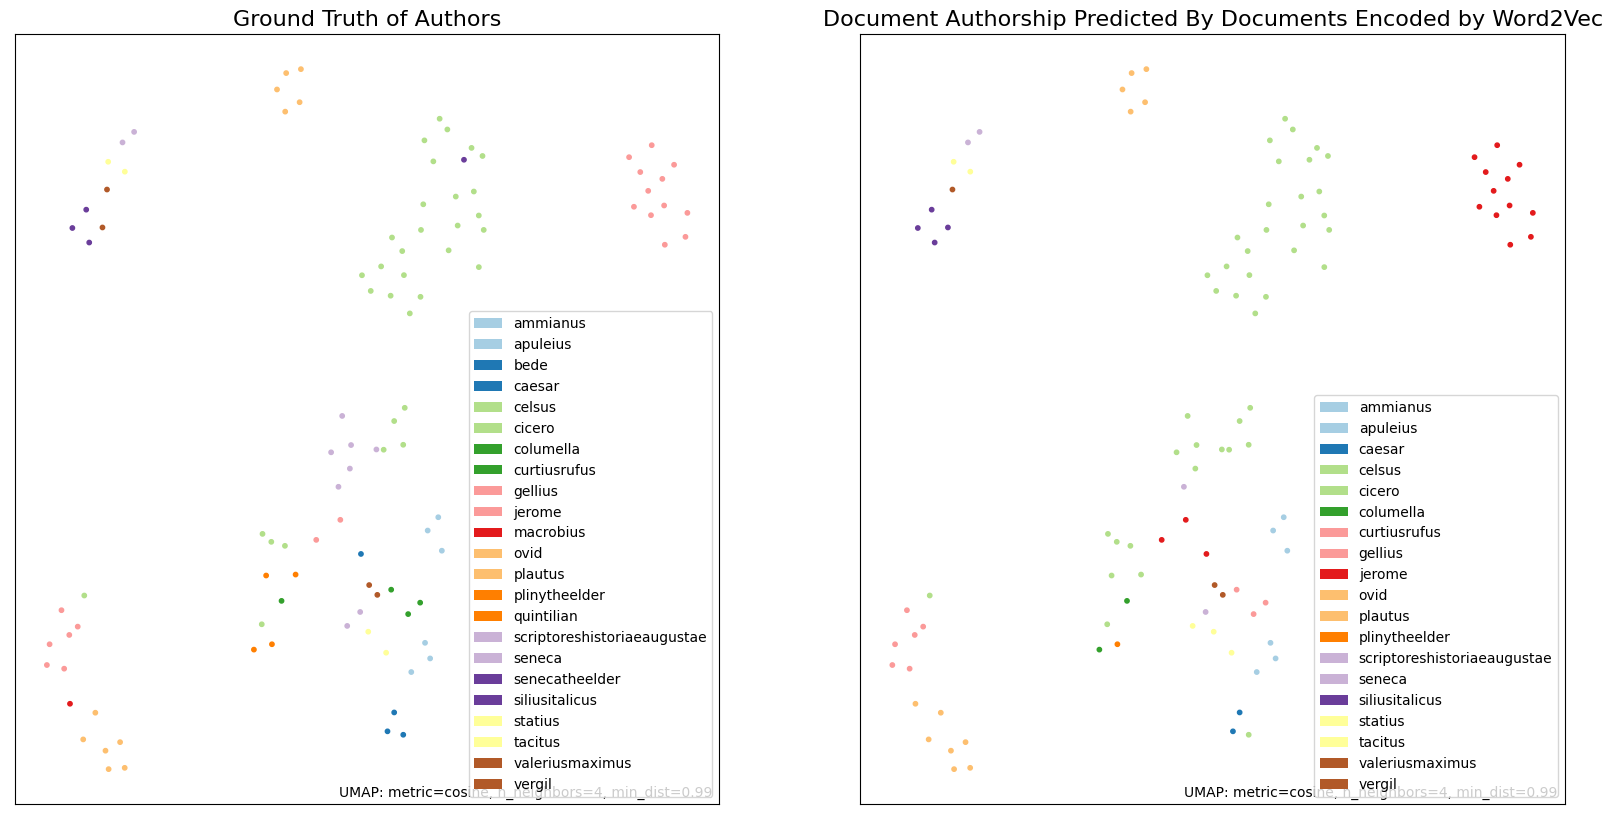

In [40]:
le = preprocessing.LabelEncoder().fit(authors)
y = le.transform(authors)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

kmeanDocCluster = KMeans(random_state=0, n_clusters=25).fit(X_train) 

kmeans_doc_pred_author = kmeanDocCluster.predict(X_test)
print("K means rand score on predicted authors by encoded documents {}".format(rand_score(kmeans_doc_pred_author, y_test)))

doc_clf = OneVsRestClassifier(SVC()).fit(X_train, y_train)
svm_doc_y_pred = doc_clf.predict(X_test)

print("\nSVM accuracy on predicted authors by encoded documents {}".format(accuracy_score(y_test, svm_doc_y_pred)))

import umap.umap_ as umap
import umap.plot as umap_plot 

mapper = umap.UMAP(random_state=42, n_components=2, min_dist=0.99, metric='cosine', n_neighbors=4).fit(X_test)

gt_authors = np.array(le.inverse_transform(y_test))
svm_predicted_docs_authors = np.array(le.inverse_transform(svm_doc_y_pred))


fig, ax = plt.subplots(1, 2, figsize=(20,10))

umap_plot.points(mapper,color_key_cmap='Paired', labels=gt_authors, ax = ax[0])
umap_plot.points(mapper,color_key_cmap='Paired', labels=svm_predicted_docs_authors, ax = ax[1])

ax[0].set_title('Ground Truth of Authors', size = 16)
ax[1].set_title("Document Authorship Predicted By Documents Encoded by Word2Vec", size=16)
plt.savefig(os.getcwd()+"/Data/Plots/SVM Documents Predicted on Word 2 Vec")



<hr>

## Rhythmic Analysis

We want to inspect the rhythmic features for different authors and the importance they play in prediction (by using a combination of $\chi^{2}$ test and training a Random Forest Model and inspecting the feature importance).
To extract the rhythmic features, we will use the code from [this paper](https://arxiv.org/abs/2110.14203), which can be found in [this repository](https://github.com/silvia-cor/SyllabicQuantity_Latin). 
<br></br>

First, we need to handle the data in the way their code wants by doing the following: 
1. a function to clean the text more fully.
2. a function that determines the scansion of the text

We want the doc_train, doc_test, cltk_train, cltk_test, and y_tr where they are:
* doc_train
* doc_test
* cltk_train
* cltk_test
* y_tr

In [7]:
from feature_extraction.general import helpers
import logging
                                       
def clean_text(input_text):
    text = re.sub("\n+", " ", input_text)
    text = re.sub("\s+", " ", text)
    text = re.sub('\[.*?\]', "", text)
    text = re.sub('[0-9]', "", text)
    text = re.sub("\n+", " ", text)
    text = re.sub("\s+", " ", text)
    text = text.lower()
    text = text.replace('v', 'u')
    text = text.replace('j', 'i')
    text = re.sub('\.\s+(?=\.)|\.\.+', "", text)
    text = re.sub("\n+", " ", text)
    text = re.sub("\s+", " ", text)
    text = re.sub("\(|\)|\[|\]", "", text)
    text = re.sub("\—|\–|\-|\_", "", text)
    text = re.sub("\‹|\›|\»|\«|\=|\/|\\|\~|\§|\*|\#|\@|\^|\“|\”", "", text)
    text = re.sub("\&dagger;|\&amacr;|\&emacr;|\&imacr;|\&omacr;|\&umacr;|\&lsquo;|\&rsquo;|\&rang;|\&lang;|\&lsqb;", "", text)
    text = re.sub("\?|\!|\:|\;", ".", text)
    text = text.replace("'", "")
    text = text.replace('"', '')
    text = text.replace(".,", ".")
    text = text.replace(",.", ".")
    text = text.replace(" .", ".")
    text = text.replace(" ,", ",")
    text = re.sub('(\.)+', ".", text)
    text = re.sub('(\,)+', "", text)
    text = text.replace("á", "a")
    text = text.replace("é", "e")
    text = text.replace("í", "i")
    text = text.replace("ó", "o")
    text = re.sub("\n+", " ", text)
    text = re.sub("\s+", " ", text)
    return text

def shuffle_arrays(data, data_cltk, author_labels, test_split:float = .25):
    assert(len(data)==len(data_cltk))
    assert(len(data_cltk)==len(author_labels))
    # convert them to arrays first
    data = np.array(data)
    data_cltk = np.array(data_cltk)
    author_labels = np.array(author_labels)
    # create a permutation for the data
    p = np.random.permutation(len(data))
    # shuffle the data accordingly
    data_shuffled = data[p]
    data_cltk_shuffled = data_cltk[p]
    author_labels_shuffled = author_labels[p]
    test_size = int(len(data_shuffled)*test_split)
    testIdx = len(data)-test_size
    
    doc_train = data_shuffled[:testIdx]
    doc_test = data_shuffled[testIdx:]
    cltk_train = data_cltk_shuffled[:testIdx]
    cltk_test = data_cltk_shuffled[testIdx:]
    y_train = author_labels_shuffled[:testIdx]
    y_test = author_labels_shuffled[testIdx:]
    
    return doc_train, doc_test, cltk_train, cltk_test, y_train, y_test


def prepare_texts(texts, authors, n_sent = 10, clausula_length: int = 200):
    assert(len(texts)==len(authors))
    macronizer = Macronizer('tag_ngram_123_backoff')
    scanner = Scansion(clausula_length=clausula_length) 
    data = []
    data_cltk = []
    author_labels = []
    logging.disable()
    error_freq = {}
    for i in range(len(texts)):
        cleaned_text = clean_text(texts[i])
        fragments = helpers.splitter(texts[i], n_sent)
        try:
            data_cltk+=helpers.metric_scansion(fragments, macronizer, scanner)
            author_labels+=[authors[i]]*len(fragments)
            data+=fragments
        except Exception as e:
            if str(e) not in error_freq:
                error_freq[str(e)] = 0
            error_freq[str(e)]+=1
        
    return data, data_cltk, author_labels, error_freq

In [8]:
italian_poets_CI = dataExp.CorpusInterface(corpus_name="italian_poets_preprocessed.pickle", shouldTokenize = True, particular_data = ["italian_poets"])
italian_poets_notPrePro_CI = dataExp.CorpusInterface(corpus_name="italian_poets.pickle", shouldTokenize = False, particular_data = ["italian_poets"])
CI = dataExp.CorpusInterface(corpus_name="text_corpus.pickle", shouldTokenize = False)

Found the existing corpus
acticussincerius had 1 pieces of work with a total of 269 characters of text
albericodamarcellise had 1 pieces of work with a total of 26 characters of text
aleandrogerolamo had 1 pieces of work with a total of 514 characters of text
angeloambrogini had 1 pieces of work with a total of 27 characters of text
angelopoliziano had 1 pieces of work with a total of 386 characters of text
corneliopaoloamalteo had 1 pieces of work with a total of 84 characters of text
dantealighieri had 1 pieces of work with a total of 17 characters of text
faustoandrelino had 1 pieces of work with a total of 697 characters of text
girolamoaccelini had 1 pieces of work with a total of 31737 characters of text
girolamoamaseo had 1 pieces of work with a total of 2465 characters of text
jacopoallegretti had 1 pieces of work with a total of 706 characters of text
marcantonioaldegati had 1 pieces of work with a total of 7413 characters of text
Found the existing corpus
acticussincerius had

### Italian Poets Plots

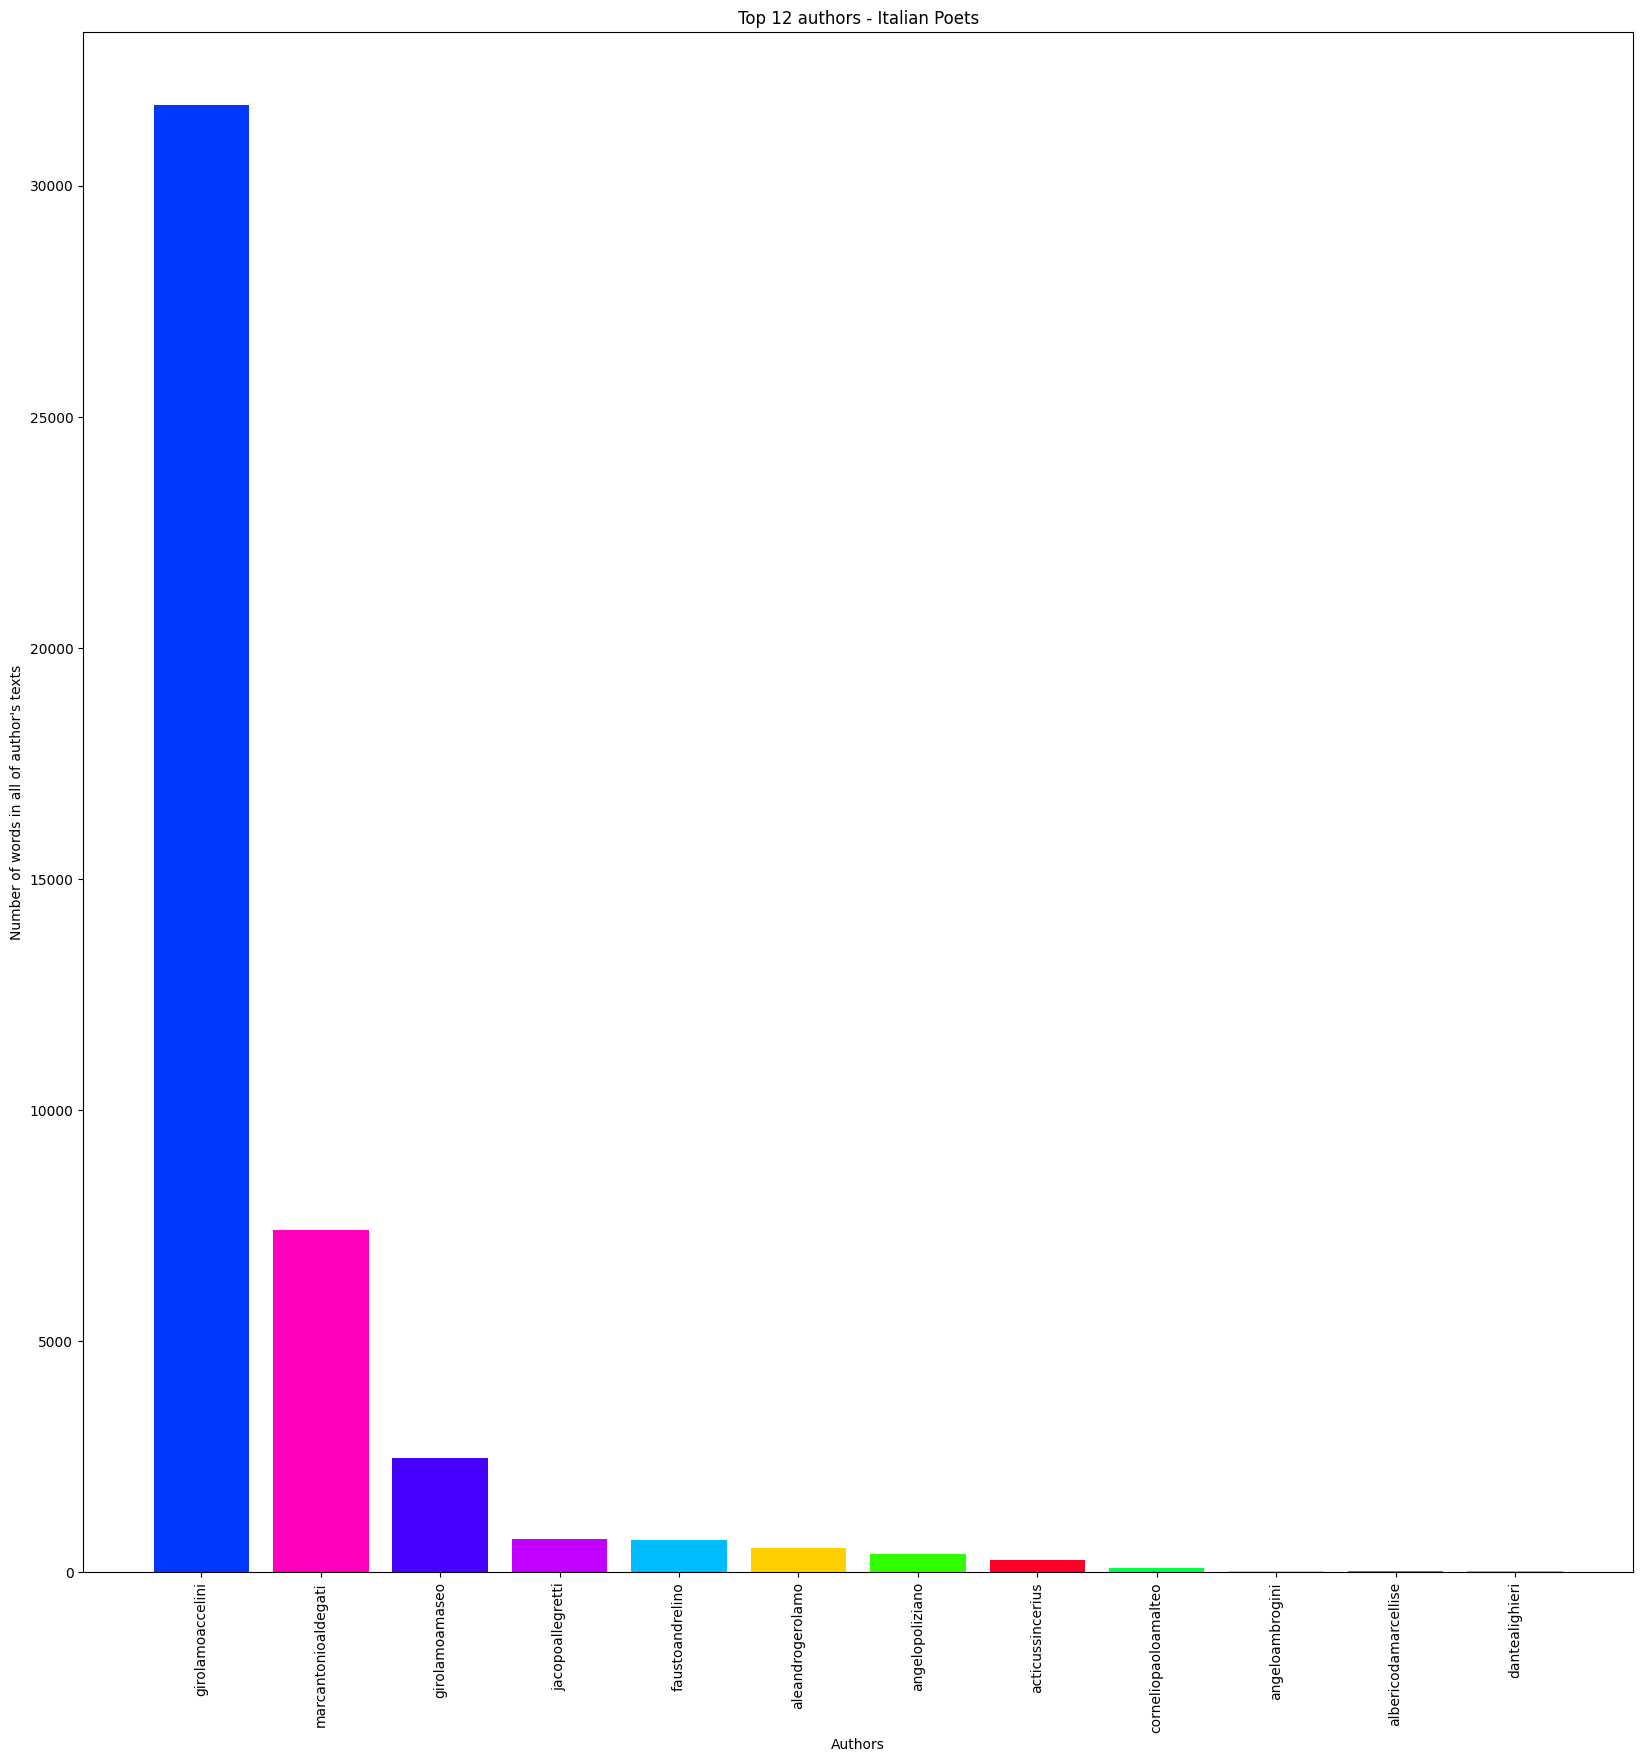

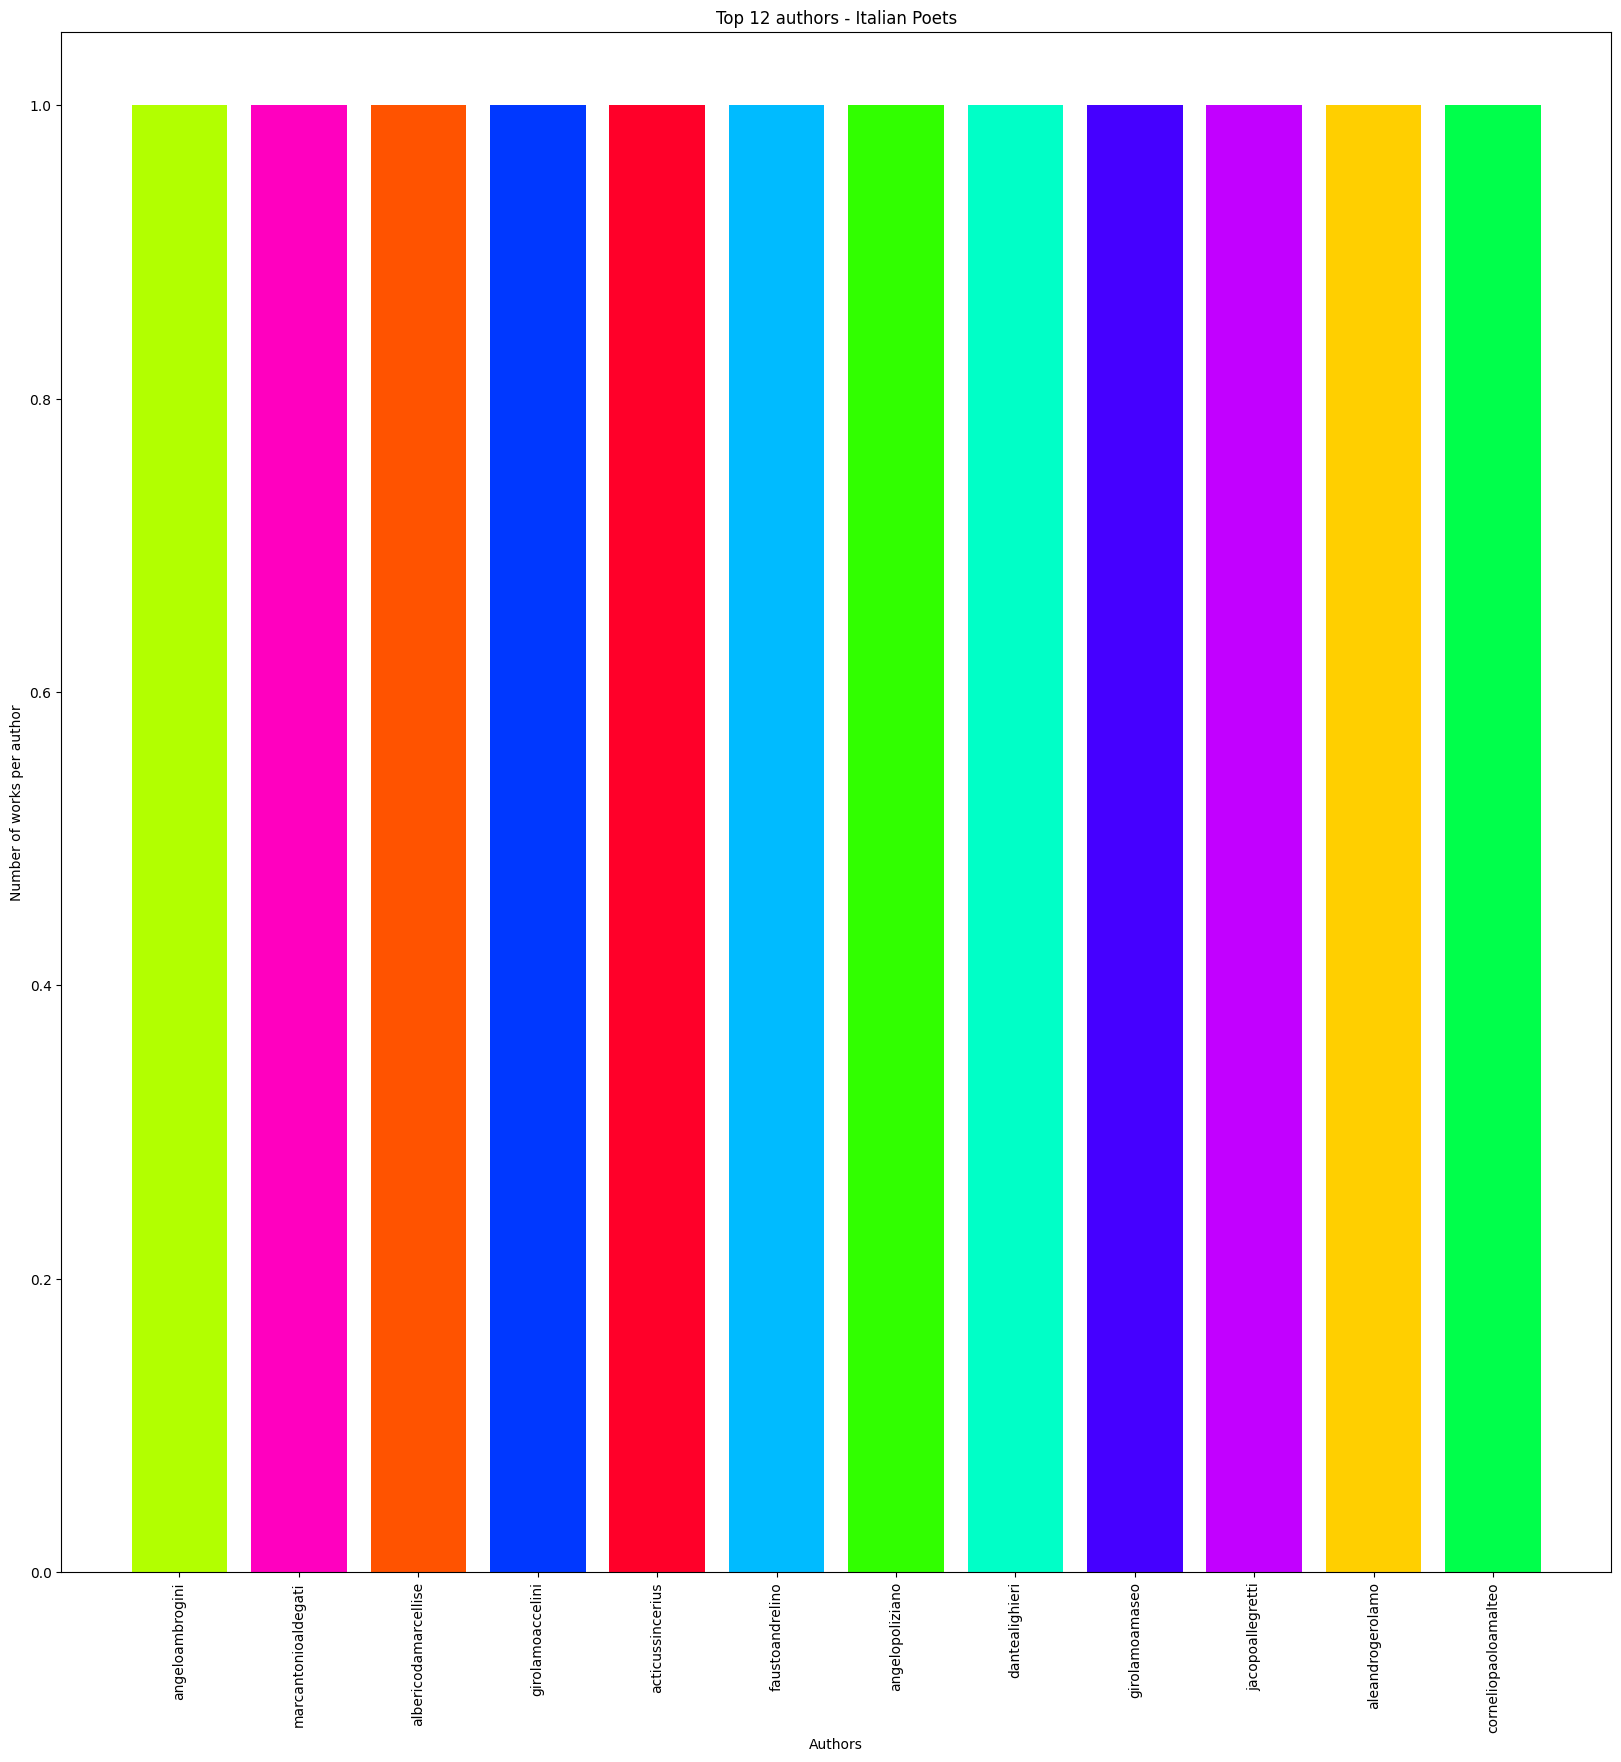

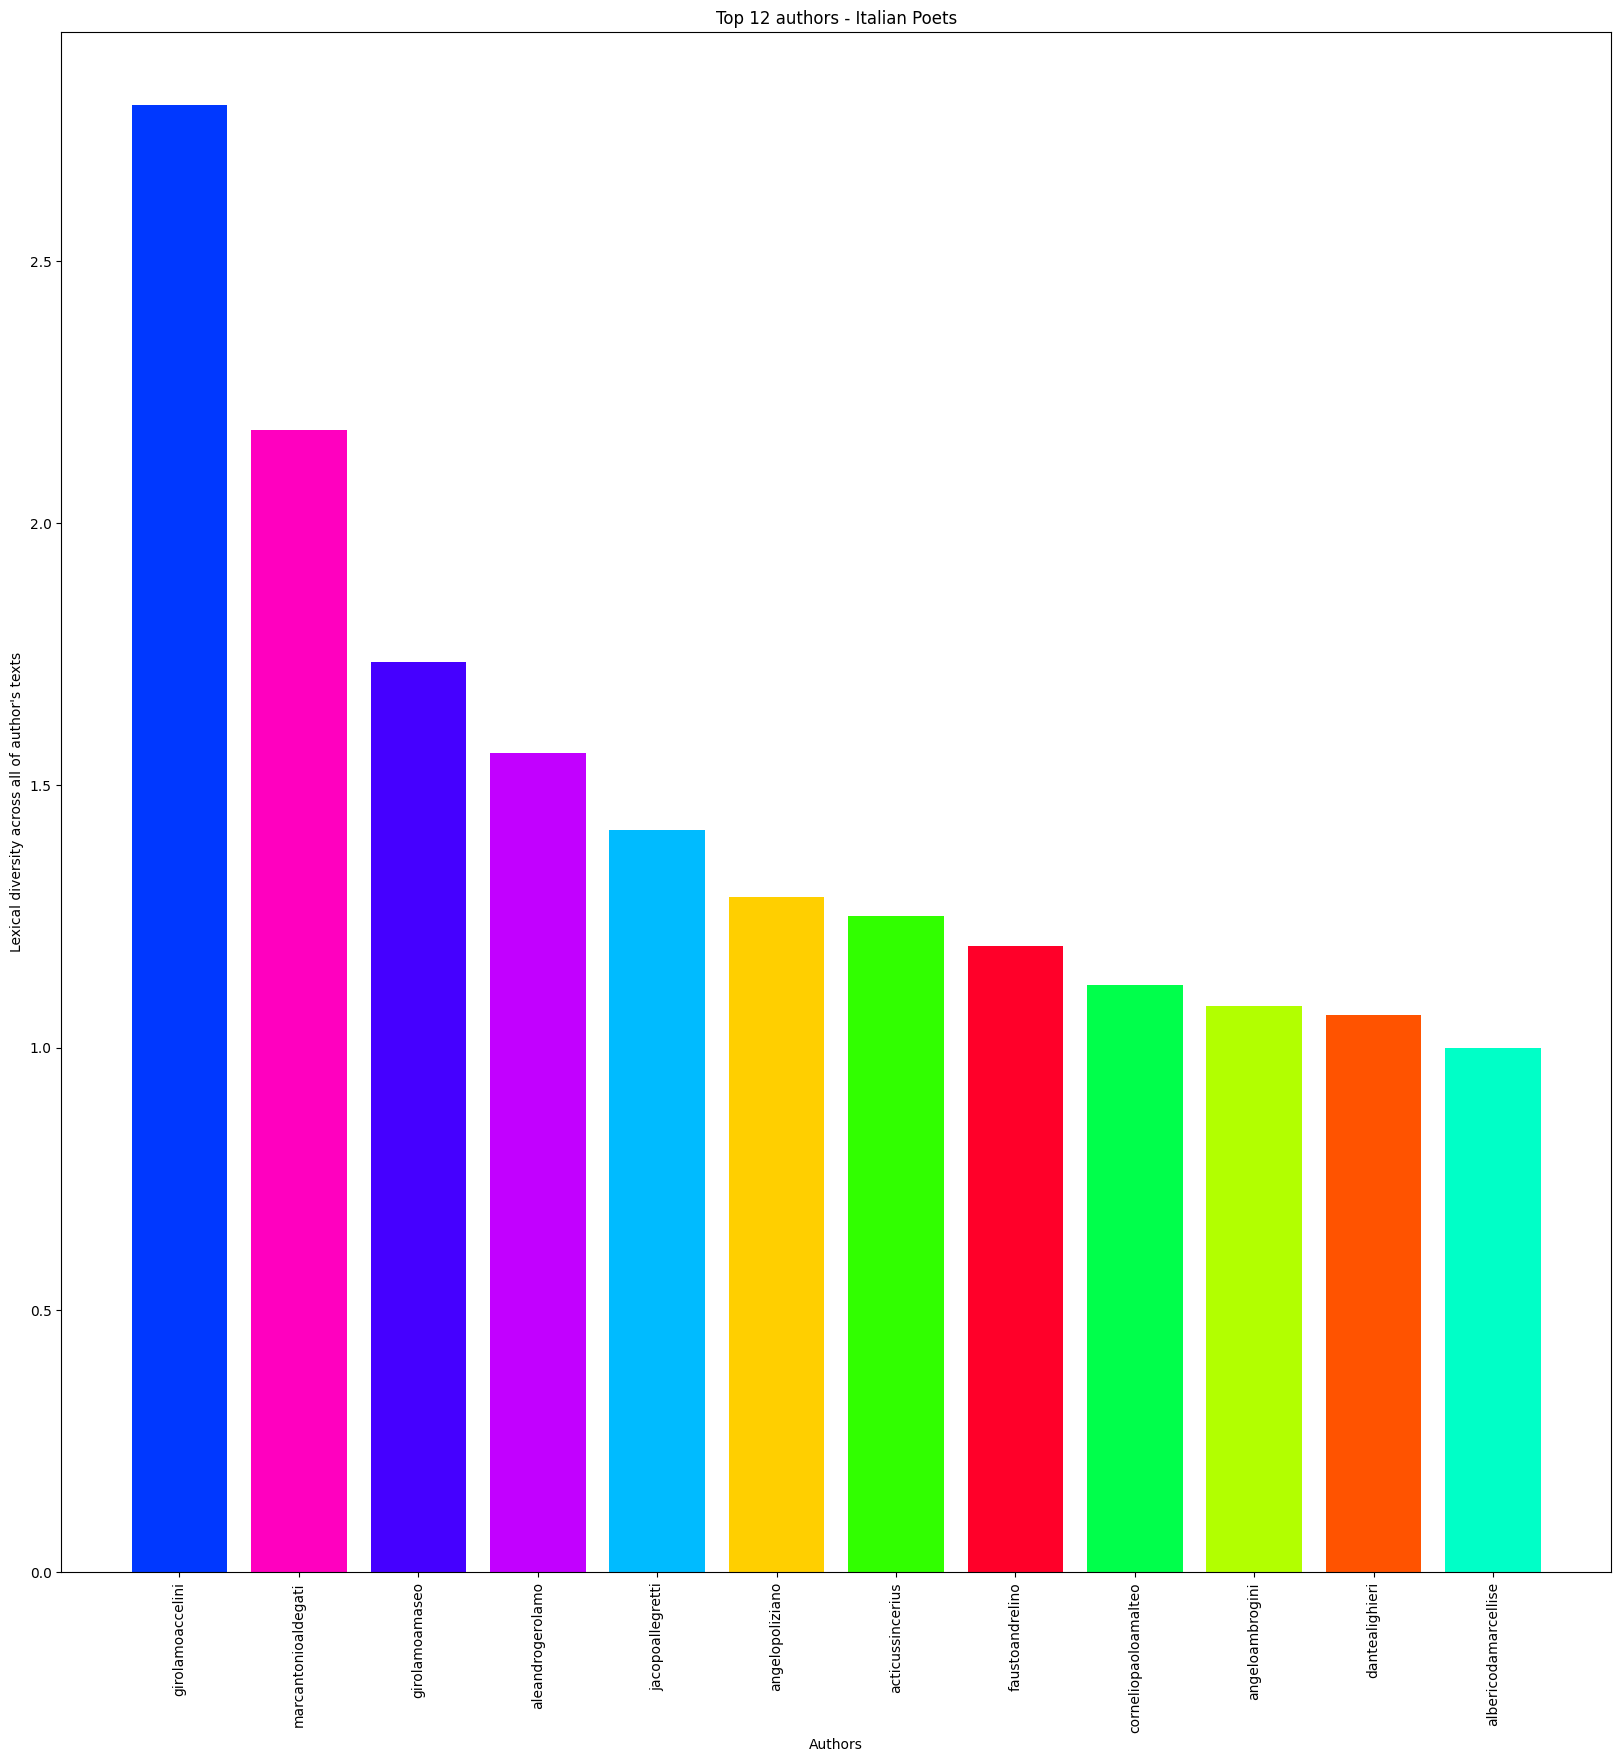

In [10]:
num_auths = len(italian_poets_CI.get_authors())
topAuthorsByTextLength, authors = plot.author_text_length_plot(italian_poets_CI, n_authors=num_auths,extra_text="Italian Poets")
topAuthorsByWorkCount = plot.author_work_count_plot(italian_poets_CI, n_authors=num_auths,extra_text="Italian Poets")
plot.author_lexical_diversity_plot(italian_poets_CI, authors,extra_text="Italian Poets")

In [11]:
plot.all_plots(italian_poets_CI, save_files=True,n_authors=num_auths,extra_text="Italian Poets")

<hr>

In [6]:
max_words = 400
texts, authors = CI.get_data(n_authors=25, max_words = max_words)

In [7]:
le = preprocessing.LabelEncoder().fit(authors)
tmp_author_labels = le.transform(authors)
data, data_cltk, author_labels, error_freq = prepare_texts(texts, tmp_author_labels, clausula_length = max_words)

metric scansion: 100%|███████████████████████████| 2/2 [00:00<00:00, 107.46it/s]


metric scansion: 100%|███████████████████████████| 2/2 [00:00<00:00, 132.71it/s]


metric scansion: 100%|███████████████████████████| 2/2 [00:00<00:00, 102.21it/s]


metric scansion: 100%|████████████████████████████| 3/3 [00:00<00:00, 98.53it/s]


metric scansion: 100%|███████████████████████████| 3/3 [00:00<00:00, 105.42it/s]


metric scansion: 100%|████████████████████████████| 2/2 [00:00<00:00, 94.02it/s]


In [8]:
# list the errors
for error in error_freq:
    print(error, error_freq[error])
print(len(data))
print(len(data_cltk))
print(len(author_labels))

list index out of range 20
1122
1122
1122


In [38]:
from feature_extraction.feature_extractor import featuresExtractor

doc_train, doc_test, cltk_train, cltk_test, y_train, y_test = shuffle_arrays(data, data_cltk, author_labels, test_split=.2)
print(len(doc_train),len(doc_test),len(cltk_train),len(cltk_test),len(y_train),len(y_test))

# parameters for SVM experiments 1
features_params_1 = {'function_words_freq': True,
                    'word_lengths_freq': True,
                    'sentence_lengths_freq': True,
                    'DVMA': True,
                    'DVSA': True,
                    'SQ': True
                    }

# parameters for SVM experiments 2
features_params_2 = {'function_words_freq': True,
                    'word_lengths_freq': True,
                    'sentence_lengths_freq': True
                    }
print("\n")
X_tr_1, X_te_1 = featuresExtractor(doc_train, doc_test, cltk_train, cltk_test, y_train, **features_params_1)
print("\nExtracting the second set of features:\n")
X_tr_2, X_te_2 = featuresExtractor(doc_train, doc_test, cltk_train, cltk_test, y_train, **features_params_2)

898 224 898 224 898 224


task function words (#features=80) [Done]
task word lengths (#features=25) [Done]
task sentence lengths (#features=100) [Done]
task DVMA 3-grams (#features=355) [Done]
task DVSA 3-grams (#features=351) [Done]
task SQ n-grams (#features=27) [Done]

Extracting the second set of features:

task function words (#features=80) [Done]
task word lengths (#features=25) [Done]
task sentence lengths (#features=100) [Done]


In [39]:
print("Shape of the first dataset {} train {} test".format(X_tr_1.shape,X_te_1.shape))
print("Shape of the second dataset {} train {} test".format(X_tr_2.shape,X_te_2.shape))
print("\nShape of the y-values {} train and {} test".format(y_train.shape,y_test.shape))

Shape of the first dataset (898, 938) train (224, 938) test
Shape of the second dataset (898, 205) train (224, 205) test

Shape of the y-values (898,) train and (224,) test


In [40]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer, accuracy_score
from sklearn.ensemble import RandomForestClassifier

## First dataset

print("\n\nStarting the first dataset:")
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
cls_one = GridSearchCV(SVC(), param_grid,
                   scoring=make_scorer(f1_score, average='macro'), n_jobs=7)
cls_one.fit(X_tr_1, y_train)
best_C = cls_one.best_params_['C']
print('Best C:', best_C)

svm_doc_y_pred_one = cls_one.predict(X_te_1)
f1 = f1_score(y_test, svm_doc_y_pred_one, average='macro')

print(f'F1: {f1:.3f}')
print("\nSVM accuracy on predicted authors by features from the documents {}".format(accuracy_score(y_test, svm_doc_y_pred_one)))
random_forest_clf_one = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_clf_one.fit(X_tr_1, y_train)
random_forest_pred_one = random_forest_clf_one.predict(X_te_1)
print("Random Forest accuracy on predicted authors by features documents {}".format(accuracy_score(y_test, random_forest_pred_one)))

## Second dataset

print("\n\nStarting with the second dataset:")
cls_two = GridSearchCV(SVC(), param_grid,
                   scoring=make_scorer(f1_score, average='macro'), n_jobs=7)
cls_two.fit(X_tr_2, y_train)
best_C = cls_two.best_params_['C']
print('Best C:', best_C)

svm_doc_y_pred_two = cls_two.predict(X_te_2)
f1 = f1_score(y_test, svm_doc_y_pred_two, average='macro')

print(f'F1: {f1:.3f}')
print("\nSVM accuracy on predicted authors by features from the documents {}".format(accuracy_score(y_test, svm_doc_y_pred_two)))
random_forest_clf_two = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_clf_two.fit(X_tr_2, y_train)
random_forest_pred_two = random_forest_clf_two.predict(X_te_2)
print("Random Forest accuracy on predicted authors by features documents {}".format(accuracy_score(y_test, random_forest_pred_two)))



Starting the first dataset:
Best C: 100
F1: 0.882

SVM accuracy on predicted authors by features from the documents 0.8839285714285714
Random Forest accuracy on predicted authors by features documents 0.8482142857142857


Starting with the second dataset:
Best C: 10
F1: 0.760

SVM accuracy on predicted authors by features from the documents 0.8169642857142857
Random Forest accuracy on predicted authors by features documents 0.8660714285714286


### McNemar Test
We are now going to run the mcnemar test on the different svms and random forests trained on the different data.

In [41]:
from mlxtend.evaluate import mcnemar_table
from mlxtend.evaluate import mcnemar

svm_mcnemar_tb = mcnemar_table(y_target=y_test, y_model1=svm_doc_y_pred_one, y_model2=svm_doc_y_pred_two)
print("SVM Results:\nmcnemar table:")
print(svm_mcnemar_tb)
svm_chi2, svm_p = mcnemar(ary=svm_mcnemar_tb, corrected=True)
print('chi-squared:', svm_chi2)
print('p-value:', svm_p)

print("\n\n")
rf_mcnemar_tb = mcnemar_table(y_target=y_test, y_model1=random_forest_pred_one, y_model2=random_forest_pred_two)
print("Random Forest Results:\nmcnemar table:")
print(rf_mcnemar_tb)
rf_chi2, rf_p = mcnemar(ary=rf_mcnemar_tb, corrected=True)
print('chi-squared:', rf_chi2)
print('p-value:', rf_p)

SVM Results:
mcnemar table:
[[183  15]
 [  0  26]]
chi-squared: 13.066666666666666
p-value: 0.00030059760744045053



Random Forest Results:
mcnemar table:
[[187   3]
 [  7  27]]
chi-squared: 0.9
p-value: 0.34278171114790873


<hr>

### Random Forest Features Importance

In [63]:
importances = random_forest_clf_one.feature_importances_
grouped_importances = [0]*6
print(len(importances))

for i in range(len(importances)):
    if i<80:
        # task function words (#features=80)
        grouped_importances[0]+=importances[i]
    elif i<(80+25):
        # task word lengths (#features=25)
        grouped_importances[1]+=importances[i]
    elif i<(80+25+100):
        # task sentence lengths (#features=100)
        grouped_importances[2]+=importances[i]
    elif i<(80+25+100+355):
        # task DVMA 3-grams (#features=355)
        grouped_importances[3]+=importances[i]
    elif i<(80+25+100+355+351):
        # task DVSA 3-grams (#features=351)
        grouped_importances[4]+=importances[i]
    else:
        # task SQ n-grams (#features=27)
        grouped_importances[5]+=importances[i]
# we now have a list of the sums of the importance for each group of feature
# let's plot how this looks
print(grouped_importances)

938
[0.05771441082129641, 0.12491062719249867, 0.2455634170902588, 0.26124433286869797, 0.25021362364567723, 0.06035358838157061]


Now, let us plot the feature importances

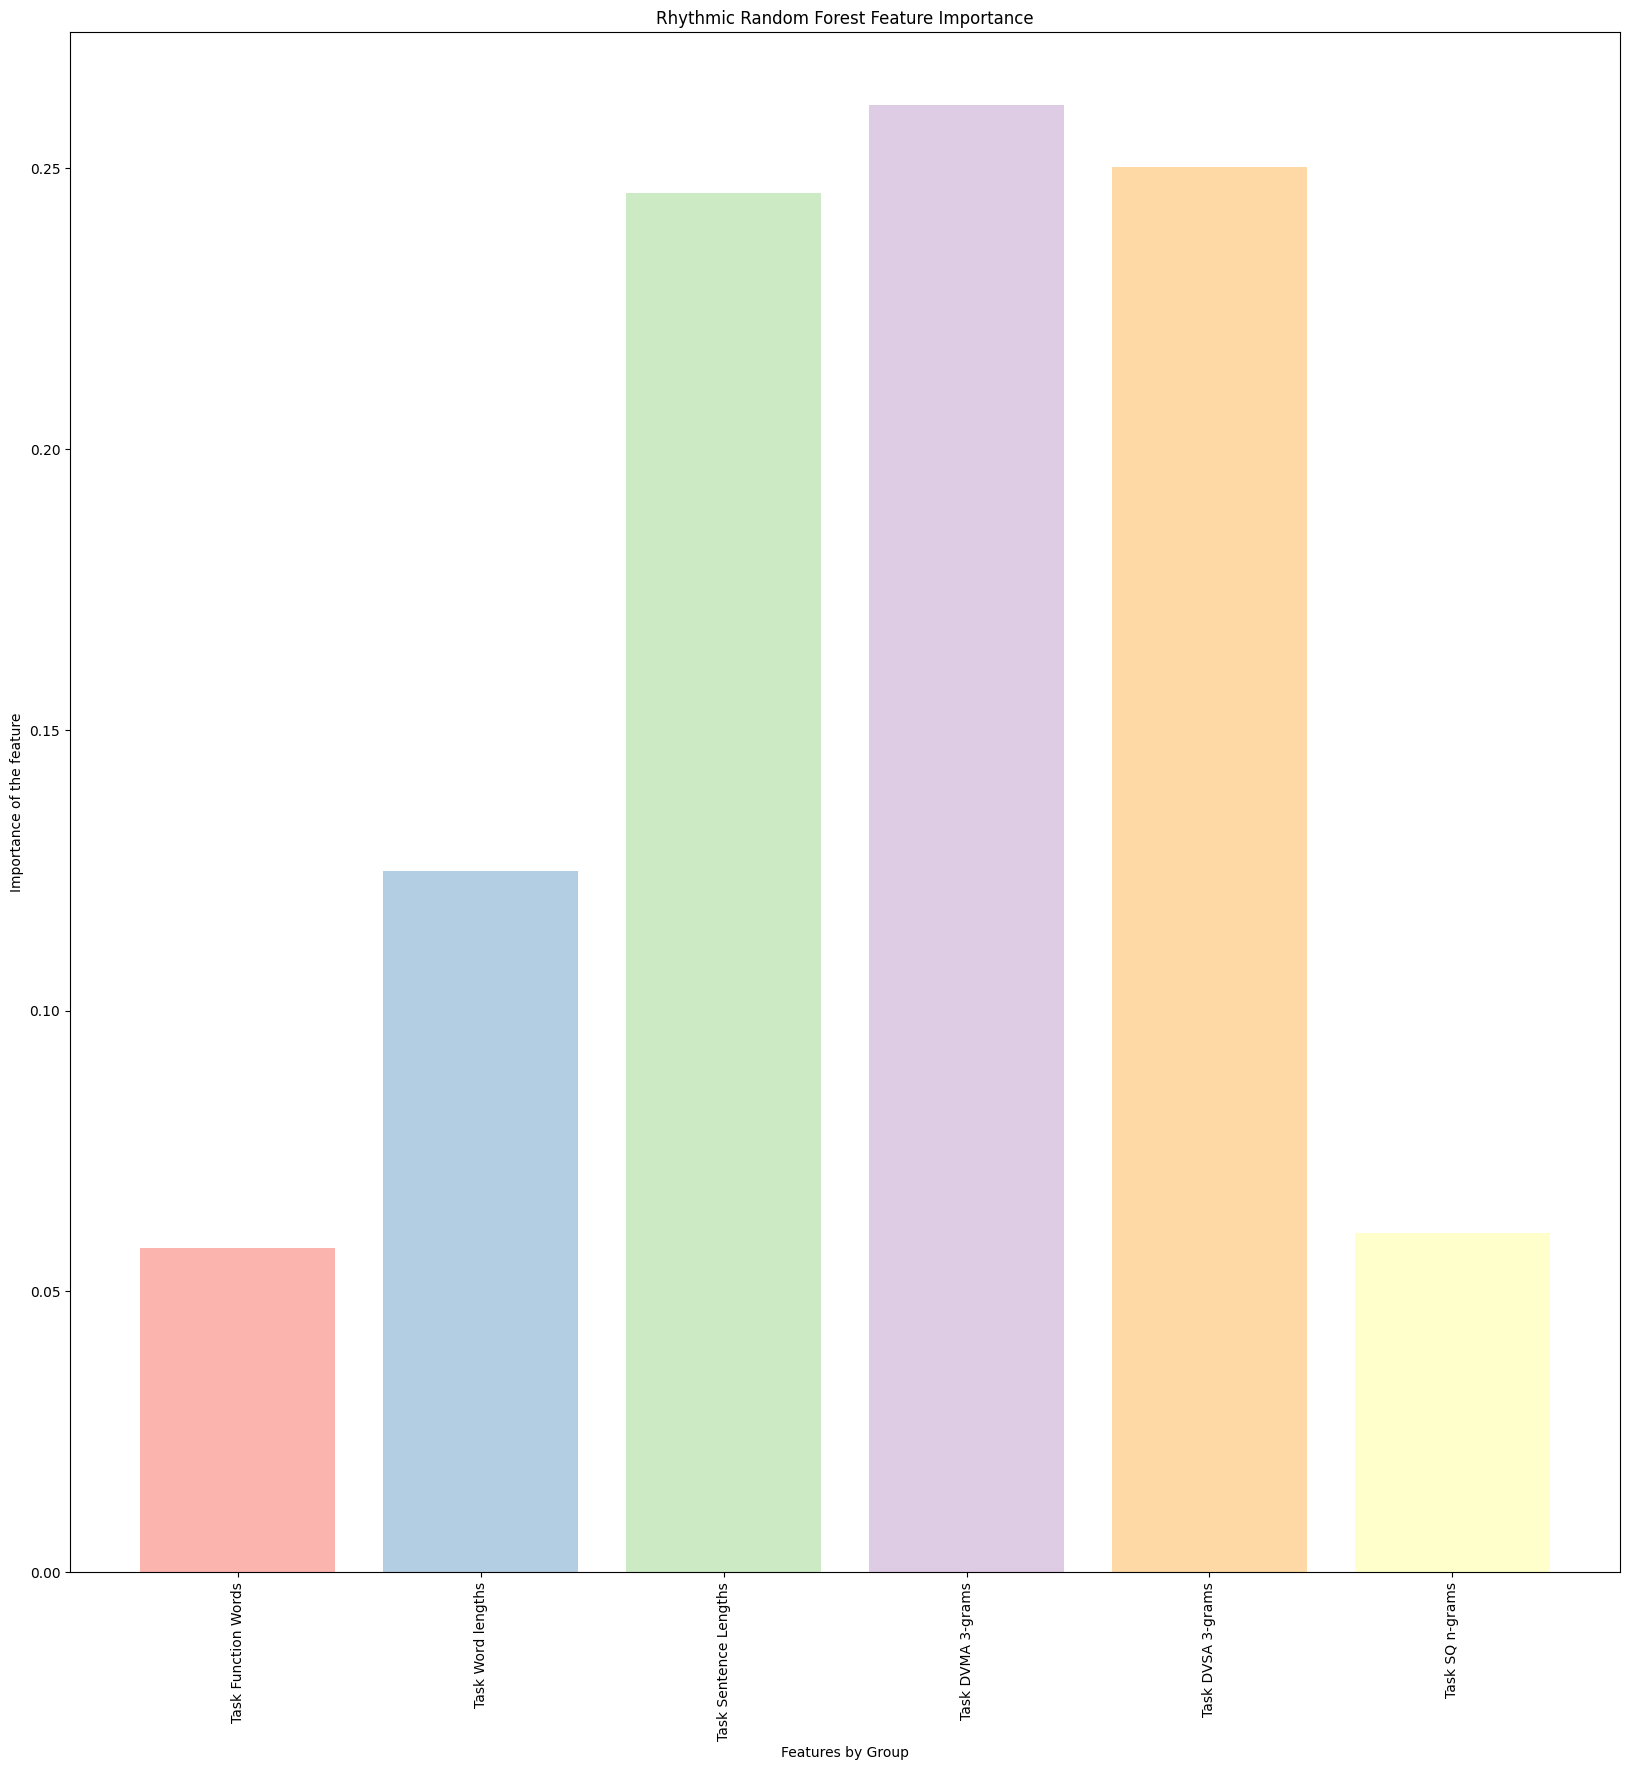

In [80]:
cmap = iter([plt.cm.Pastel1(i) for i in range(len(grouped_importances))])

plt.rcParams["figure.figsize"] = (20,20)
plt.title("Rhythmic Random Forest Feature Importance")
x = ["Task Function Words", "Task Word lengths", "Task Sentence Lengths", "Task DVMA 3-grams", "Task DVSA 3-grams", "Task SQ n-grams"]
for i in range(len(grouped_importances)):
    plt.bar(x[i],grouped_importances[i], color =[next(cmap)])
plt.xticks(rotation='vertical')
plt.xlabel("Features by Group")
plt.ylabel("Importance of the feature")
plt.savefig(os.getcwd()+"/Data/Plots/Rhythmic Random Forest Feature Importance.png")